In [ ]:
p = np.array([math.sin(x/2)+x/16 for x in range(30)]) + 3# + (np.random.random(L)-0.5)*2
p = torch.from_numpy(p.astype(np.float32))*10
dp = p[1:] - p[:-1]
hold = compute_hold(p)
plt.plot(p, ".-")
plt.plot(hold)
plt.plot(dp)

fsize = 3
features = []
for i in range(p.shape[0]):
    if i < fsize-1:
        features.append(torch.zeros(fsize))
    else:
        features.append(p[i-fsize+1:i+1] - p[i])

features = torch.vstack(features)
for i in range(fsize-1, 10):
    plt.plot(range(i-fsize+1, i+1), features[i].numpy())
plt.grid("on")
plt.tight_layout()

In [1]:
import torch
import matplotlib.pyplot as plt
from utils import PyConfig
from data_processing.train_dataset import next_price_prediction
from tqdm import tqdm
from ml.models import autoregress_sequense
from ml.models import E2EModel
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

%reload_ext autoreload
%autoreload 2

In [2]:
def compute_hold(p):
    hold = p if p[-1] - p[0] >= 0 else -p
    return hold - hold[0]

DEVICE = "cuda"

cfg = PyConfig("zz.py").test()
features, p = next_price_prediction(cfg)
features = torch.from_numpy(features).to(DEVICE)
p = torch.from_numpy(p).to(DEVICE)
dp = p[1:] - p[:-1]
hold = compute_hold(p)

(4132, 8) (4132,)


In [7]:
inp_shape = (1, features.shape[1])
model = E2EModel(inp_shape, 4)
print(summary(model, inp_shape, device="cpu"))
model.to(DEVICE)

Layer (type:depth-idx)                   Output Shape              Param #
E2EModel                                 [1, 1]                    --
├─LayerNorm: 1-1                         [1, 8]                    16
├─Linear: 1-2                            [1, 4]                    36
├─InstanceNorm1d: 1-3                    [1, 4]                    --
├─ReLU: 1-4                              [1, 4]                    --
├─Linear: 1-5                            [1, 4]                    20
├─InstanceNorm1d: 1-6                    [1, 4]                    --
├─ReLU: 1-7                              [1, 4]                    --
├─Linear: 1-8                            [1, 1]                    5
├─Tanh: 1-9                              [1, 1]                    --
Total params: 77
Trainable params: 77
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


E2EModel(
  (fc_features_in): Linear(in_features=8, out_features=4, bias=True)
  (fc_hid): Linear(in_features=4, out_features=4, bias=True)
  (fc_out): Linear(in_features=4, out_features=1, bias=True)
  (norm_hid): InstanceNorm1d((4, 4), eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (norm_in): LayerNorm((1, 8), eps=1e-05, elementwise_affine=True)
  (norm_out): InstanceNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (relu): ReLU()
  (tanh): Tanh()
)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, maximize=True)
tb_writer = SummaryWriter()

In [9]:
num_epochs = 300
for epoch in tqdm(list(range(num_epochs)), desc="Training"):
    optimizer.zero_grad()
    loss, _ = autoregress_sequense(model, p, dp, features, epoch=epoch, device=DEVICE)
    loss -= hold[-1]
    loss.backward()
    optimizer.step()
    tb_writer.add_scalar("Loss/train", loss, epoch)
tb_writer.flush()

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Training: 100%|██████████| 300/300 [12:49<00:00,  2.56s/it]


<BarContainer object of 4132 artists>

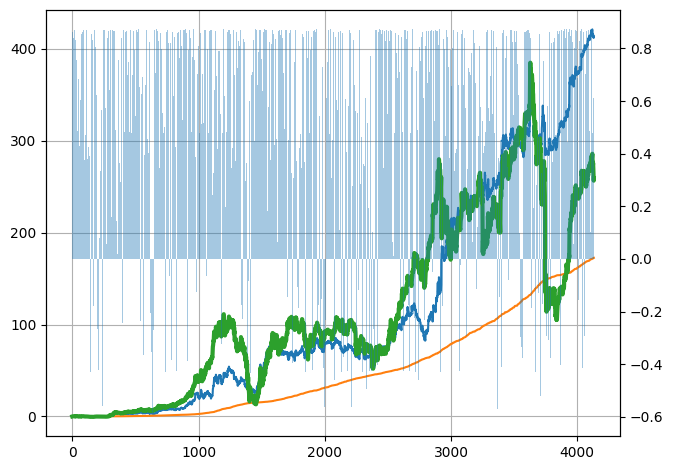

In [10]:
model.eval()
output_seq, result_seq, fee_seq = autoregress_sequense(model, p, dp, features, output_sequense=True, device=DEVICE)

fig, ax1 = plt.subplots()
# ax1.plot(p - p[0], linewidth=3)
ax1.plot(result_seq.cumsum(0))
ax1.plot(fee_seq.cumsum(0))
ax1.plot(hold.to("cpu"), linewidth=3)
ax1.grid("on")
plt.tight_layout()
plt.grid("on")

ax2 = ax1.twinx()
ax2.bar(list(range(output_seq.shape[0])), height=output_seq, width=1, alpha=0.4)

In [35]:
dp

tensor([ 0.0100, -0.0900, -0.2000, -0.1800, -0.1500, -0.1600, -0.1800, -0.2100,
        -0.2300, -0.2800, -0.3000, -0.2100, -0.2400, -0.2500, -0.2300, -0.2800,
        -0.4100, -0.4200, -0.4200], device='cuda:0')